In [143]:
%load_ext memory_profiler

######################
#import useful modules
######################

import sys
sys.path.append("/home/gula/Desktop/Work_capella/Python/Python_Modules_p3/") 

from matplotlib.offsetbox import AnchoredText
from Modules import *
from Modules_gula import *

The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler


In [144]:
###################################################################################
# Load simul [only the eurec4a region]
###################################################################################

simulname = 'gigatl6_1h'; time = 700
simul = load(simul = simulname + ' [700,1400,150,850,[1,100,1]] ' + format(time), light=False, output=False)

#simulname = 'gigatl6_1h'; time = 700
#simul = load(simulname , time=time, light=False, output=False)

#simulname = 'gigatl3_1h_avg_eurec4a'; time = 240
#%memit simul = load(simul = simulname, time = time, light=False, output=False)

#########
'''
# for eurec4a
ix1,ix2 = 770 -200 , 1270+200
iy1,iy2 = 2000-200 , 2500+200

coordinates = ' [' + format(iy1) + ',' + format(iy2) + ',' + format(ix1) + ',' + format(ix2) + ',[1,200,1]] '

simulname = 'gigatl3_1h_mean'; 
%memit simul = load(simul = simulname + coordinates + '0', light=False, output=True)
'''

"\n# for eurec4a\nix1,ix2 = 770 -200 , 1270+200\niy1,iy2 = 2000-200 , 2500+200\n\ncoordinates = ' [' + format(iy1) + ',' + format(iy2) + ',' + format(ix1) + ',' + format(ix2) + ',[1,200,1]] '\n\nsimulname = 'gigatl3_1h_mean'; \n%memit simul = load(simul = simulname + coordinates + '0', light=False, output=True)\n"

## Plotting functions

In [152]:
# Define horizontal coordinates (deg, km, or grid points)
##############

coord = 'points'

if coord=='deg':
    #using lon,lat
    lon = simul.x; lat = simul.y
    xlabel = 'lon'; ylabel = 'lat'
elif coord=='km':
    # using km
    [lon,lat] = np.meshgrid(np.arange(simul.x.shape[0])+simul.coord[2],np.arange(simul.x.shape[1])+simul.coord[0])
    lon = (lon/np.mean(simul.pm)*1e-3).T
    lat = (lat/np.mean(simul.pn)*1e-3).T
    lon -= lon.min()
    lat -= lat.min()
    xlabel = 'km'; ylabel = 'km'
elif coord=='points':
    # using grid points
    [lon,lat] = np.meshgrid(np.arange(simul.x.shape[0])+simul.coord[2],np.arange(simul.x.shape[1])+simul.coord[0])
    lon,lat = lon.T,lat.T
    xlabel = 'grid pts'; ylabel = 'grid pts'

##############



def myplot(data, ax,vmin=-1,vmax=1.,title=r'$\zeta/f$',contour=True):
    
    if data.shape[0]==lon.shape[0]:
        x,y = lon,lat
    else:
        x,y = tools.rho2psi(lon),tools.rho2psi(lat)
        
    plt.pcolormesh(x,y,ma.masked_invalid(data),\
                   cmap = plot.ncview_colormap('blu_red'),vmin=vmin,vmax=vmax,shading='auto');
    plt.colorbar()
    if contour: CS0 = ax.contour(x,y,ma.masked_invalid(data),range(-100,100,10),colors = ('k',), linewidths = (1.,)); 

    CS1 = ax.contour(lon,lat,simul.topo,[100,1000,2000,3000],colors = ('k',), linewidths = (.5,)); 
    #plt.clabel(CS1, fmt = '%2.0f', colors = 'k', fontsize=6)  ; 

    plt.xlabel(xlabel,fontsize=18); plt.ylabel(ylabel,fontsize=18)
    plt.title(title, fontsize=20)

    if coord=='deg':
        plt.axis([-65,-30,-10,25])

## Computing streamfunction

In [146]:
####

def find_nearest(x,y,lon, lat):
    dist = (x-lon)**2 + (y-lat)**2
    return np.unravel_index(dist.argmin(),dist.shape)

####





def psi_from_uvrot(u,v):
    # compute a streamfunction using the rotational part:

    psir =  tools_g.rot2streams(u,v,simul.pm,simul.pn,variable=True) 
    
    psir *=  1e-4
    i0,j0 = find_nearest(simul.x,simul.y,-48, 0)
    
    return psir - psir[i0,j0]



def psi_from_uv(u,v,rot=True):

    if rot:
        ud,vd = tools_g.div2uvs(u,v,simul.pm,simul.pn)
        u1,v1 = u-ud, v-vd; del ud,vd
    else:
        u1,v1 = u,v
        
    u1 = u1 * 2 /(simul.pn[1:,:]+simul.pn[:-1,:])
    v1 = v1 * 2 /(simul.pm[:,1:]+simul.pm[:,:-1])

    lx,ly = simul.pm.shape[0]-1,simul.pm.shape[1]-1

    psi = np.zeros((lx,ly))*np.nan

    psi[0,:] = -1*np.cumsum(u1[0,:-1])
    psi[:,0] = np.cumsum(v1[:-1,0])

    for i in range(1,lx):
        for j in range(1,ly):
            psi[i,j]= psi[i-1,j-1] + (v1[i,j-1] - u1[i,j])
            
    del u1,v1
    
    psi *=  1e-4
    i0,j0 = find_nearest(simul.x,simul.y,-48, 0)
    
    return psi - psi[i0,j0]






In [170]:
%%time

mask = copy(simul.mask)
mask[mask==0] = np.nan

depth=0
u = var('u',simul,depths=[depth]).data
v = var('v',simul,depths=[depth]).data


#1. barotropic streamfunction:
#psib = var('psi',simul).data * 1e-6 * tools.rho2psi(mask)


#1. streamfunction at depth using full velocity
psi_uv = psi_from_uv(u,v,rot=False) * tools.rho2psi(mask)

#2. streamfunction at depth using rotational part of vel.
psi_uv2 = psi_from_uv(u,v,rot=True) * tools.rho2psi(mask)

#3. streamfunction at depth using rotational part of vel. (different function)
psi_uvrot = psi_from_uvrot(u,v)* mask


#4.  SSH
zeta = var('zeta',simul).data


creating matrix A
using poisson_matrix_fast
creating matrix A
using poisson_matrix_fast
CPU times: user 58.5 s, sys: 54.4 s, total: 1min 52s
Wall time: 15.9 s


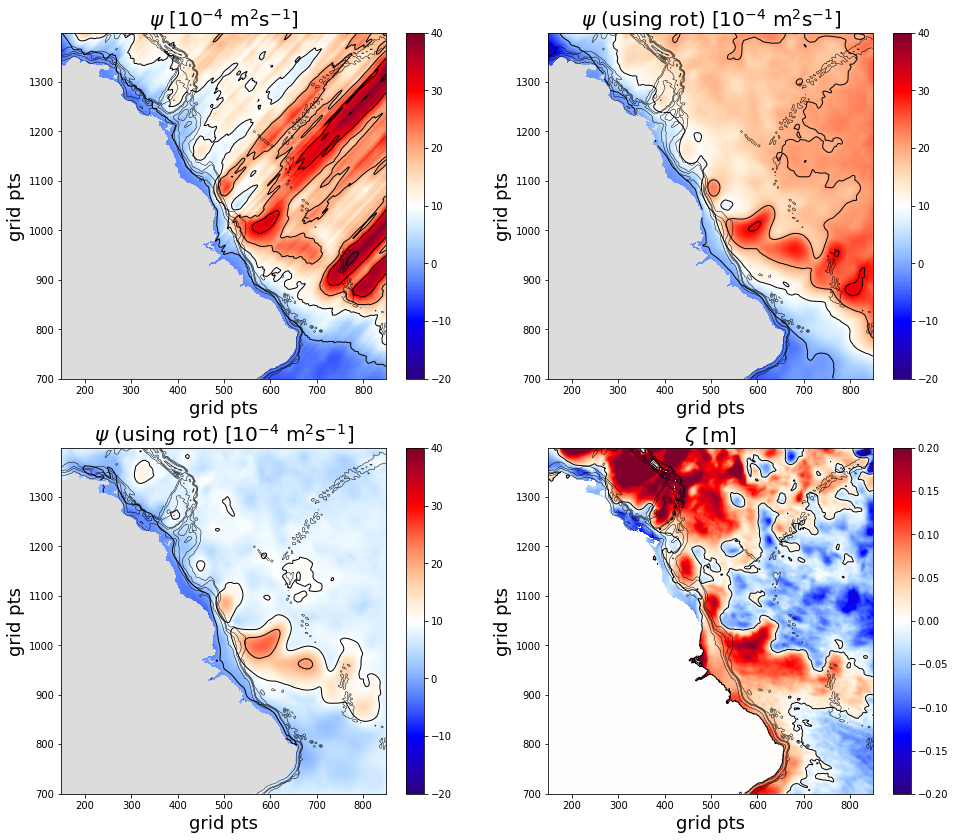

In [171]:
################################

fig = plt.figure(figsize=(16.0,14.0)) 

#################################################

ax1 = fig.add_subplot(221,facecolor='Gainsboro')
#myplot(psib,ax1,vmin=-30,vmax=30,title=r'barotropic $\Psi$ [Sv]')
myplot(psi_uv,ax1,vmin=-20,vmax=40,title=r'$\psi$ [10$^{-4}$ m$^{2}$s$^{-1}$]')

#################################################

ax2 = fig.add_subplot(222,facecolor='Gainsboro')
myplot(psi_uv2,ax2,vmin=-20,vmax=40,title=r'$\psi$ (using rot) [10$^{-4}$ m$^{2}$s$^{-1}$]')

#################################################

ax3 = fig.add_subplot(223,facecolor='Gainsboro')
myplot(psi_uvrot,ax3,vmin=-20,vmax=40,title=r'$\psi$ (using rot) [10$^{-4}$ m$^{2}$s$^{-1}$]')

#################################################

ax4 = fig.add_subplot(224,facecolor='Gainsboro')
myplot(zeta,ax4,vmin=-0.2,vmax=0.2,title=r'$\zeta$ [m]')


# Streamplot

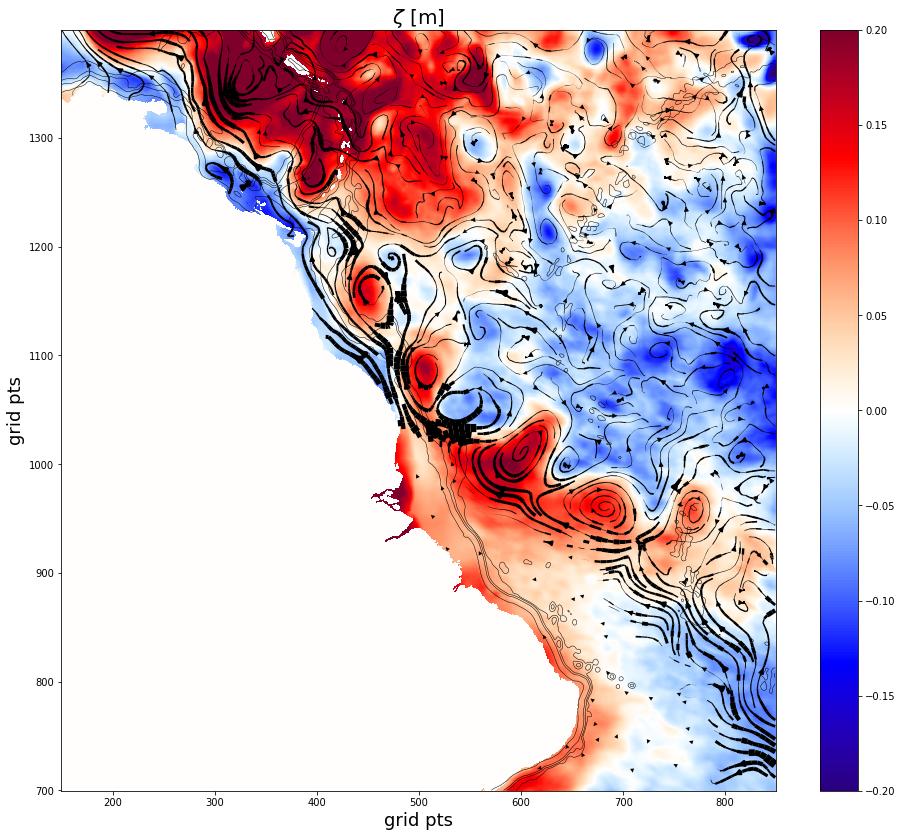

In [167]:
#################################################

fig = plt.figure(figsize=(16.0,14.0)) 

#################################################

ax1 = fig.add_subplot(111,facecolor='Gainsboro')
myplot(zeta,ax1,vmin=-0.2,vmax=0.2,title=r'$\zeta$ [m]',contour=False)


speed = np.sqrt(tools.u2rho(u)**2 + tools.v2rho(v)**2)
lw = 10 * speed / np.nanmax(speed) # Line Widths
hqs = plt.streamplot(lon[:,0].T,lat[0,:].T,tools.u2rho(u).T,tools.v2rho(v).T, density=4 \
                           , color="k", linewidth=lw, arrowsize=1, zorder=4)

#################################################
